In [1]:
import os
import torch
import timm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms, models
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import confusion_matrix
from PIL import Image


In [2]:
DATA_DIR = os.path.join(os.curdir, "data")

In [3]:
TRAIN_SIZE = 0.8
BATCH_SIZE = 32

In [4]:
#read about stratification
# hint: to keep distribution 
preprocess = ViT_B_16_Weights.DEFAULT.transforms()
data_dir = os.path.join(os.curdir, "data", "raw","dataset")
dataset = datasets.ImageFolder(data_dir, transform=preprocess)

train_size = int(TRAIN_SIZE * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
print(dataset.classes)
print(len(dataset.classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
11


In [6]:
# Load the pre-trained ViT-B/16 model
model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# Modify the final classification layer to have 11 output classes
model.heads.head = nn.Linear(model.heads.head.in_features, 11)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)

num_epochs = 30
model.train()

train_loss = []
val_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    for index , (inputs,labels) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_count += 1
    
    epoch_train_loss = running_loss / batch_count
    train_loss.append(epoch_train_loss)
    running_loss = 0.0
    batch_count = 0

    #running validation:
    model.eval()
    val_running_loss = 0.0
    val_batch_count = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_batch_count += 1
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / val_batch_count
    val_loss.append(epoch_val_loss)
    accuracy = val_correct / val_total
    print(f"Epoch {epoch + 1}, Training Loss: {epoch_train_loss:.4f}|| Validation Accuracy: {accuracy:.6f} || Validation Loss: {epoch_val_loss:.6f}")
    model.train()


Epoch 1, Training Loss: 1.8178|| Validation Accuracy: 0.683673 || Validation Loss: 1.311644
Epoch 2, Training Loss: 1.0098|| Validation Accuracy: 0.813411 || Validation Loss: 0.831072
Epoch 3, Training Loss: 0.6820|| Validation Accuracy: 0.842566 || Validation Loss: 0.620308
Epoch 4, Training Loss: 0.5272|| Validation Accuracy: 0.855685 || Validation Loss: 0.514566
Epoch 5, Training Loss: 0.4371|| Validation Accuracy: 0.865889 || Validation Loss: 0.451062
Epoch 6, Training Loss: 0.3767|| Validation Accuracy: 0.876093 || Validation Loss: 0.411665
Epoch 7, Training Loss: 0.3316|| Validation Accuracy: 0.884840 || Validation Loss: 0.382416
Epoch 8, Training Loss: 0.2969|| Validation Accuracy: 0.892128 || Validation Loss: 0.352655
Epoch 9, Training Loss: 0.2669|| Validation Accuracy: 0.892128 || Validation Loss: 0.338926
Epoch 10, Training Loss: 0.2407|| Validation Accuracy: 0.897959 || Validation Loss: 0.323249
Epoch 11, Training Loss: 0.2167|| Validation Accuracy: 0.900875 || Validation L

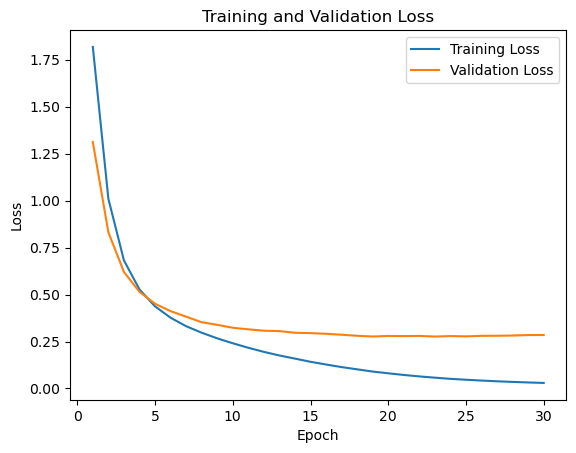

In [8]:
# Plotting the validation vs training loss curve after training
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

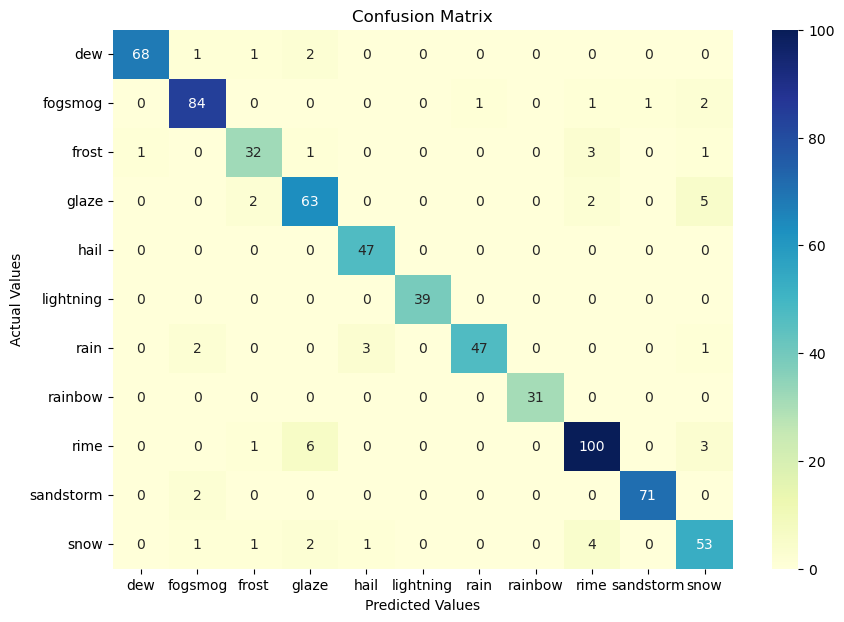

Accuracy: 0.9865
Precision: [0.98550725 0.93333333 0.86486486 0.85135135 0.92156863 1.
 0.97916667 1.         0.90909091 0.98611111 0.81538462]
Recall: [0.94444444 0.94382022 0.84210526 0.875      1.         1.
 0.88679245 1.         0.90909091 0.97260274 0.85483871]
F1 Score: [0.96453901 0.93854749 0.85333333 0.8630137  0.95918367 1.
 0.93069307 1.         0.90909091 0.97931034 0.83464567]


In [9]:
def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    return cm, TP, FP, FN, TN

conf_matrix, TP, FP, FN, TN = compute_metrics(model, val_loader, device)
'''print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")'''

# Visualize the confusion matrix using Seaborn heatmap
cm_df = pd.DataFrame(conf_matrix, index =[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']],
                     columns=[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']])


plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
# Compute additional metrics if needed
accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())
precision = TP/(TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


In [10]:
#why is test accuracy a bad measure of performance, what should I use instead, use confusion matrix, F1 score, and recall
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        '''
        if test_total % 160 == 0:
            print(f"Processed {test_total} test samples")
        '''
test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.6f}")

Test Accuracy: 0.917031


why is Accuracy bad?
The accuracy metric computes how many times a model made a correct prediction across the entire dataset. This can be a reliable metric only if the dataset is class-balanced; that is, each class of the dataset has the same number of samples which is not the case in most situations including our own data.

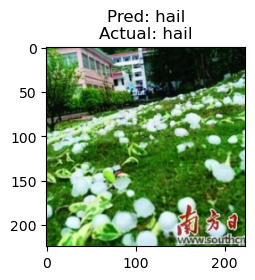

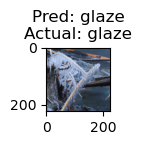

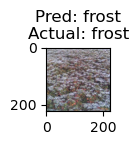

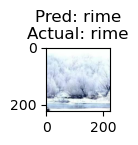

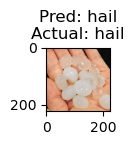

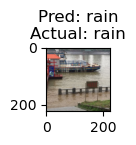

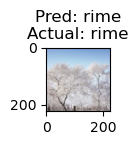

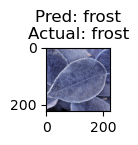

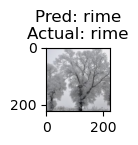

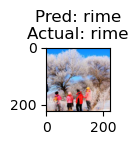

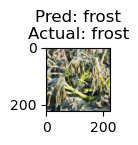

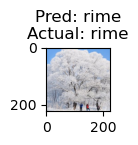

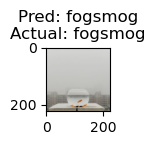

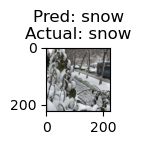

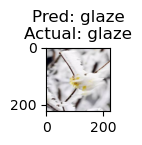

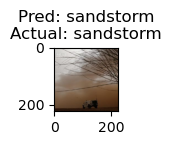

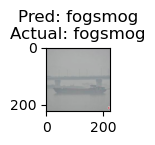

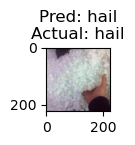

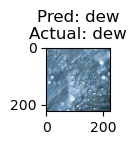

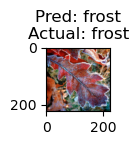

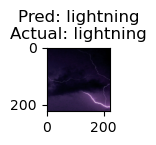

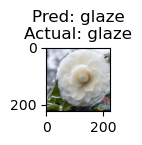

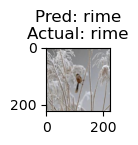

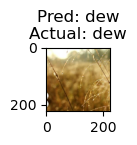

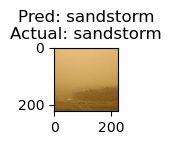

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display images in a grid
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get 25 random images
indices = random.sample(range(len(dataset)), 25)
random_images = [dataset[i] for i in indices]

# Prepare the model for evaluation
model.eval()

# Create a figure
plt.figure(figsize=(15, 15))

# Iterate over the random images
for i, (image, label) in enumerate(random_images):
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    label = torch.tensor([label]).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    # Move image back to CPU for plotting
    image = image.squeeze(0).cpu()
    
    # Display image with title
    ax = plt.subplot(5, 5, i + 1)
    imshow(image, title=f"Pred: {dataset.classes[predicted.item()]}\nActual: {dataset.classes[label.item()]}")
    ax.axis('on')

# Show the plot
plt.show()


In [12]:
new_image_path = "/mnt/c/Users/malsh/OneDrive - Trinity College/Desktop/IMG classification/test4.webp"

if not os.path.exists(new_image_path):
    print(f"File not found: {new_image_path}")
else:
    new_image = Image.open(new_image_path).convert("RGB")
    new_image = preprocess(new_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    model.eval()
    with torch.no_grad():
        output = model(new_image)
        _, predicted = torch.max(output, 1)

    predicted_label = dataset.classes[predicted.item()]
    print(f"Predicted label for the new image: {predicted_label}")

Predicted label for the new image: fogsmog
